<a href="https://colab.research.google.com/github/alessandrossC/ML-for-people/blob/main/%22LSTM_%D0%B4%D0%BB%D1%8F_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D1%83%D0%B2%D0%B0%D0%BD%D0%BD%D1%8F_%D1%87%D0%B0%D1%81%D0%BE%D0%B2%D0%B8%D1%85_%D1%80%D1%8F%D0%B4%D1%96%D0%B2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [5]:
passengers = df['Passengers'].values.astype(np.float32)
passengers

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [9]:
# Обчислюємо індекс, який відділяє тренувальні та валідаційні дані
train_size = int(len(passengers) * 0.67)

# Розбивка
train, test = passengers[:train_size], passengers[train_size:]

# Перевіримо розміри
print(f"Train size: {len(train)}")
print(f"Validation size: {len(test)}")

# Виводимо приклад
print("Train example:", train[:5])
print("Validation example:", test[:5])

Train size: 96
Validation size: 48
Train example: [112. 118. 132. 129. 121.]
Validation example: [315. 301. 356. 348. 355.]


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [12]:
import numpy as np
import torch

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:i+lookback])
        y.append(dataset[i + lookback])

    # Перетворюємо X і y на NumPy масиви перед створенням тензорів
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    # Додаємо розмірність features (останню)
    X = torch.tensor(X).unsqueeze(-1)
    y = torch.tensor(y).unsqueeze(-1)
    return X, y

In [13]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [14]:
import torch
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(AirModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM-шар
        self.lstm = nn.LSTM(
            input_size=1,         # одна ознака на таймстеп
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True      # перша розмірність — розмір батчу
        )

        # Лінійний шар для перетворення з hidden_size → 1
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x має форму [batch_size, seq_len, 1]
        lstm_out, _ = self.lstm(x)          # lstm_out: [batch, seq_len, hidden_size]
        out = self.fc(lstm_out[:, -1, :])   # беремо останній таймстеп → [batch, 1]
        return out

In [17]:
import torch

# Створення моделі
model = AirModel(hidden_size=50, num_layers=1)

# Створення вхідного тензора: batch_size=1, seq_len=1, input_size=1
input_tensor = torch.tensor([[[112.0]]], dtype=torch.float32)

# Прогноз від моделі
output = model(input_tensor)

# Виведення результату
print("Model prediction:", output)

Model prediction: tensor([[-0.2841]], grad_fn=<AddmmBackward0>)


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [18]:
from torch.utils.data import TensorDataset, DataLoader

# Створення об'єкта TensorDataset
train_dataset = TensorDataset(X_train, y_train)

# Створення DataLoader з батчами по 8 і перемішуванням
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

In [19]:
# Перевіримо перший батч
for batch_X, batch_y in train_loader:
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)
    break

Batch X shape: torch.Size([8, 1, 1])
Batch y shape: torch.Size([8, 1])


**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import numpy as np

# Параметри
num_epochs = 2000
losses = []

# Модель
model = AirModel(hidden_size=50, num_layers=1)

# Функція втрат і оптимізатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Цикл навчання
for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_losses = []

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    avg_loss = np.mean(epoch_losses)
    losses.append(avg_loss)

    # Валідація раз на 100 епох
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train)
            train_rmse = np.sqrt(mean_squared_error(y_train.numpy(), train_pred.numpy()))

            test_pred = model(X_test)
            test_rmse = np.sqrt(mean_squared_error(y_test.numpy(), test_pred.numpy()))

        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

Epoch 100: train RMSE 78.2764, test RMSE 245.8474
Epoch 200: train RMSE 71.2374, test RMSE 218.4193
Epoch 300: train RMSE 71.1491, test RMSE 215.0396
Epoch 400: train RMSE 71.1503, test RMSE 215.4905
Epoch 500: train RMSE 71.1493, test RMSE 215.2566
Epoch 600: train RMSE 71.1491, test RMSE 215.1064
Epoch 700: train RMSE 71.1491, test RMSE 215.0424
Epoch 800: train RMSE 71.1491, test RMSE 215.1302
Epoch 900: train RMSE 71.1492, test RMSE 215.1916
Epoch 1000: train RMSE 71.1493, test RMSE 214.9251
Epoch 1100: train RMSE 71.1493, test RMSE 215.2448
Epoch 1200: train RMSE 71.1499, test RMSE 215.4125
Epoch 1300: train RMSE 71.1492, test RMSE 215.2109
Epoch 1400: train RMSE 71.1492, test RMSE 215.1889
Epoch 1500: train RMSE 71.1492, test RMSE 215.0172
Epoch 1600: train RMSE 71.1491, test RMSE 215.1825
Epoch 1700: train RMSE 71.1493, test RMSE 215.2767
Epoch 1800: train RMSE 71.1492, test RMSE 215.2449
Epoch 1900: train RMSE 71.1491, test RMSE 215.0833
Epoch 2000: train RMSE 71.1491, test RMS

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

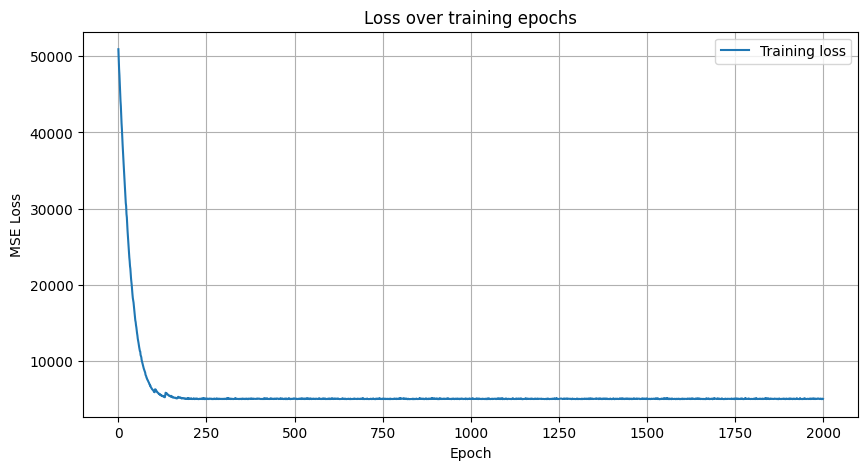

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss over training epochs')
plt.grid(True)
plt.legend()
plt.show()

Після 200–300 епох модель більше не покращується.

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

<ipython-input-25-d227f90329df>:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:train_size] = model(X_train)[:, -1]
<ipython-input-25-d227f90329df>:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[train_size+lookback:len(passengers)] = model(X_test)[:, -1]


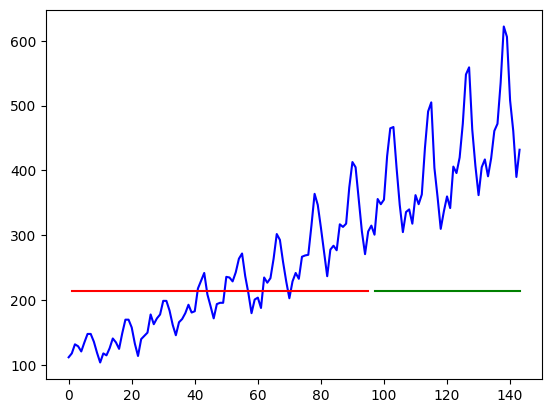

In [25]:
def plot_predicts():
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(passengers) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(passengers) * np.nan
      test_plot[train_size+lookback:len(passengers)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(passengers, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts()

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [26]:
# Нова модель
model_big = AirModel(hidden_size=100, num_layers=1)

# Нова функція втрат та оптимізатор
criterion_big = nn.MSELoss()
optimizer_big = optim.Adam(model_big.parameters(), lr=0.01)

# Список втрат
losses_big = []

# Навчання
num_epochs = 2000
for epoch in range(1, num_epochs + 1):
    model_big.train()
    batch_losses = []
    for batch_X, batch_y in train_loader:
        optimizer_big.zero_grad()
        output = model_big(batch_X)
        loss = criterion_big(output, batch_y)
        loss.backward()
        optimizer_big.step()
        batch_losses.append(loss.item())
    losses_big.append(np.mean(batch_losses))

    if epoch % 100 == 0:
        model_big.eval()
        with torch.no_grad():
            train_pred = model_big(X_train).squeeze().numpy()
            test_pred = model_big(X_test).squeeze().numpy()
            train_rmse = np.sqrt(mean_squared_error(y_train.numpy(), train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test.numpy(), test_pred))
        print(f"[BIG] Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

[BIG] Epoch 100: train RMSE 71.6529, test RMSE 223.0624
[BIG] Epoch 200: train RMSE 71.1516, test RMSE 215.6584
[BIG] Epoch 300: train RMSE 71.1506, test RMSE 215.5335
[BIG] Epoch 400: train RMSE 71.1498, test RMSE 215.3916
[BIG] Epoch 500: train RMSE 71.1495, test RMSE 214.8881
[BIG] Epoch 600: train RMSE 71.1491, test RMSE 215.0225
[BIG] Epoch 700: train RMSE 71.1493, test RMSE 214.9549
[BIG] Epoch 800: train RMSE 71.5652, test RMSE 222.3160
[BIG] Epoch 900: train RMSE 71.1491, test RMSE 215.0219
[BIG] Epoch 1000: train RMSE 71.1495, test RMSE 215.3400
[BIG] Epoch 1100: train RMSE 71.1491, test RMSE 215.0486
[BIG] Epoch 1200: train RMSE 71.1491, test RMSE 215.1712
[BIG] Epoch 1300: train RMSE 71.1494, test RMSE 214.8936
[BIG] Epoch 1400: train RMSE 71.1498, test RMSE 214.8089
[BIG] Epoch 1500: train RMSE 71.1492, test RMSE 214.9982
[BIG] Epoch 1600: train RMSE 71.1493, test RMSE 214.9400
[BIG] Epoch 1700: train RMSE 71.1491, test RMSE 215.0587
[BIG] Epoch 1800: train RMSE 71.1503, te

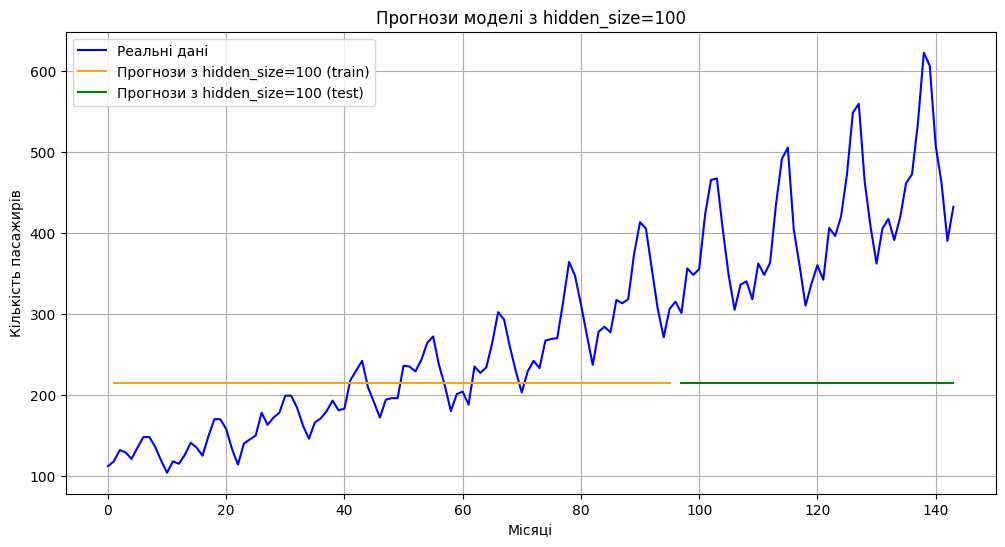

In [27]:
def plot_big_predicts():
    with torch.no_grad():
        train_pred = model_big(X_train).detach().numpy().squeeze()
        test_pred = model_big(X_test).detach().numpy().squeeze()

        train_plot = np.full_like(passengers, np.nan, dtype=np.float32)
        test_plot = np.full_like(passengers, np.nan, dtype=np.float32)

        train_plot[lookback:train_size] = train_pred
        test_plot[train_size + lookback:] = test_pred

    plt.figure(figsize=(12, 6))
    plt.plot(passengers, label='Реальні дані', color='blue')
    plt.plot(train_plot, label='Прогнози з hidden_size=100 (train)', color='orange')
    plt.plot(test_plot, label='Прогнози з hidden_size=100 (test)', color='green')
    plt.title("Прогнози моделі з hidden_size=100")
    plt.xlabel("Місяці")
    plt.ylabel("Кількість пасажирів")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_big_predicts()

Модель не дала відутного покращення